In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow import keras

from bitsback import *

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

orig_x_train = x_train
orig_x_test = x_test

# Scale to be between [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(x_train.shape)

mnist_digits = x_train
mnist_digits = np.expand_dims(mnist_digits, -1)

(60000, 28, 28)


[-1.         -1.         -1.         -0.3647059   0.88235295  0.9843137
  0.9843137  -0.06666667 -0.8039216  -1.        ]


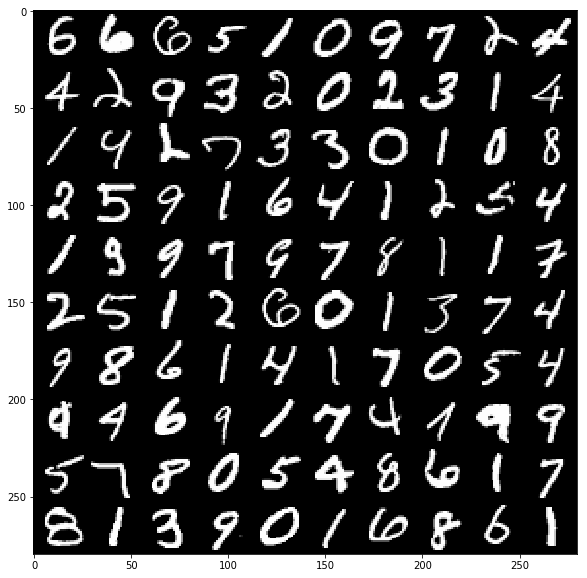

In [3]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

print(mnist_digits[0, 14, 10:20].reshape(10))
display_digits(mnist_digits)

In [4]:
enc = keras.models.load_model('vae-encoder')
dec = keras.models.load_model('vae-decoder')

In [5]:
stack = np.random.randint(low=0, high=(1 << 32) - 1, size=50, dtype=np.uint32).tolist()
stack.append(int(np.random.randint(low=(1 << 32), high=(1 << 63))))
init_stack = stack.copy()
num_images = len(orig_x_test)
quant_bits = 16
stats = {}
for i in range(num_images):
    stack = bitsback_append(orig_x_test[i:(i+1)], stack, enc, dec, quant_bits=quant_bits, stats=stats)
    if (i > 0 and (i+1) % 10 == 0) or (i == num_images - 1):
        orig = 784 * (i + 1)
        compress = 4 * len(stack) + 4
        bits_per_dim = compress * 8 / orig
        print('[%s]: N=%05d, bits per dim=%.4f' % (datetime.now(), i+1, bits_per_dim))

[2021-01-31 19:40:47.047910]: N=00010, bits per dim=2.0163
[2021-01-31 19:40:51.034841]: N=00020, bits per dim=1.9694
[2021-01-31 19:40:55.039139]: N=00030, bits per dim=1.9429
[2021-01-31 19:40:58.963625]: N=00040, bits per dim=1.8878
[2021-01-31 19:41:02.872386]: N=00050, bits per dim=1.8482
[2021-01-31 19:41:06.871330]: N=00060, bits per dim=1.8517
[2021-01-31 19:41:10.905564]: N=00070, bits per dim=1.8682
[2021-01-31 19:41:14.942921]: N=00080, bits per dim=1.8673
[2021-01-31 19:41:19.003222]: N=00090, bits per dim=1.8780
[2021-01-31 19:41:23.056222]: N=00100, bits per dim=1.8804
[2021-01-31 19:41:27.041770]: N=00110, bits per dim=1.8835
[2021-01-31 19:41:31.019981]: N=00120, bits per dim=1.8724
[2021-01-31 19:41:35.095067]: N=00130, bits per dim=1.8813
[2021-01-31 19:41:39.212491]: N=00140, bits per dim=1.8860
[2021-01-31 19:41:43.160727]: N=00150, bits per dim=1.8803
[2021-01-31 19:41:47.114732]: N=00160, bits per dim=1.8773
[2021-01-31 19:41:51.162487]: N=00170, bits per dim=1.88

[2021-01-31 19:50:08.842327]: N=01400, bits per dim=1.8871
[2021-01-31 19:50:12.874548]: N=01410, bits per dim=1.8867
[2021-01-31 19:50:17.128286]: N=01420, bits per dim=1.8878
[2021-01-31 19:50:21.235165]: N=01430, bits per dim=1.8885
[2021-01-31 19:50:25.270337]: N=01440, bits per dim=1.8876
[2021-01-31 19:50:29.304188]: N=01450, bits per dim=1.8881
[2021-01-31 19:50:33.435754]: N=01460, bits per dim=1.8893
[2021-01-31 19:50:37.484023]: N=01470, bits per dim=1.8905
[2021-01-31 19:50:41.506830]: N=01480, bits per dim=1.8903
[2021-01-31 19:50:45.565664]: N=01490, bits per dim=1.8900
[2021-01-31 19:50:49.657946]: N=01500, bits per dim=1.8903
[2021-01-31 19:50:53.703043]: N=01510, bits per dim=1.8898
[2021-01-31 19:50:57.769842]: N=01520, bits per dim=1.8897
[2021-01-31 19:51:01.874684]: N=01530, bits per dim=1.8903
[2021-01-31 19:51:05.993530]: N=01540, bits per dim=1.8911
[2021-01-31 19:51:10.028122]: N=01550, bits per dim=1.8907
[2021-01-31 19:51:14.116602]: N=01560, bits per dim=1.89

[2021-01-31 20:01:26.290647]: N=03070, bits per dim=1.8891
[2021-01-31 20:01:30.301694]: N=03080, bits per dim=1.8889
[2021-01-31 20:01:34.334865]: N=03090, bits per dim=1.8889
[2021-01-31 20:01:38.331004]: N=03100, bits per dim=1.8884
[2021-01-31 20:01:42.372679]: N=03110, bits per dim=1.8883
[2021-01-31 20:01:46.440822]: N=03120, bits per dim=1.8884
[2021-01-31 20:01:50.497726]: N=03130, bits per dim=1.8882
[2021-01-31 20:01:54.578853]: N=03140, bits per dim=1.8883
[2021-01-31 20:01:58.601564]: N=03150, bits per dim=1.8881
[2021-01-31 20:02:02.643783]: N=03160, bits per dim=1.8880
[2021-01-31 20:02:06.680795]: N=03170, bits per dim=1.8879
[2021-01-31 20:02:10.799193]: N=03180, bits per dim=1.8881
[2021-01-31 20:02:14.886497]: N=03190, bits per dim=1.8883
[2021-01-31 20:02:18.941304]: N=03200, bits per dim=1.8883
[2021-01-31 20:02:23.023497]: N=03210, bits per dim=1.8885
[2021-01-31 20:02:27.053339]: N=03220, bits per dim=1.8882
[2021-01-31 20:02:31.213252]: N=03230, bits per dim=1.88

[2021-01-31 20:10:52.058019]: N=04460, bits per dim=1.8935
[2021-01-31 20:10:56.146359]: N=04470, bits per dim=1.8936
[2021-01-31 20:11:00.255515]: N=04480, bits per dim=1.8934
[2021-01-31 20:11:04.390277]: N=04490, bits per dim=1.8937
[2021-01-31 20:11:08.469471]: N=04500, bits per dim=1.8935
[2021-01-31 20:11:12.573161]: N=04510, bits per dim=1.8937
[2021-01-31 20:11:16.753673]: N=04520, bits per dim=1.8941
[2021-01-31 20:11:20.776854]: N=04530, bits per dim=1.8938
[2021-01-31 20:11:24.863153]: N=04540, bits per dim=1.8937
[2021-01-31 20:11:28.962678]: N=04550, bits per dim=1.8939
[2021-01-31 20:11:33.185129]: N=04560, bits per dim=1.8944
[2021-01-31 20:11:37.165148]: N=04570, bits per dim=1.8940
[2021-01-31 20:11:41.263612]: N=04580, bits per dim=1.8942
[2021-01-31 20:11:45.277115]: N=04590, bits per dim=1.8938
[2021-01-31 20:11:49.333957]: N=04600, bits per dim=1.8935
[2021-01-31 20:11:53.459698]: N=04610, bits per dim=1.8935
[2021-01-31 20:11:57.641312]: N=04620, bits per dim=1.89

[2021-01-31 20:20:23.540893]: N=05850, bits per dim=1.9025
[2021-01-31 20:20:27.640454]: N=05860, bits per dim=1.9027
[2021-01-31 20:20:31.805293]: N=05870, bits per dim=1.9030
[2021-01-31 20:20:35.848395]: N=05880, bits per dim=1.9032
[2021-01-31 20:20:39.941978]: N=05890, bits per dim=1.9035
[2021-01-31 20:20:43.983276]: N=05900, bits per dim=1.9034
[2021-01-31 20:20:48.121500]: N=05910, bits per dim=1.9033
[2021-01-31 20:20:52.121846]: N=05920, bits per dim=1.9032
[2021-01-31 20:20:56.179523]: N=05930, bits per dim=1.9033
[2021-01-31 20:21:00.366265]: N=05940, bits per dim=1.9034
[2021-01-31 20:21:04.607148]: N=05950, bits per dim=1.9036
[2021-01-31 20:21:08.800933]: N=05960, bits per dim=1.9038
[2021-01-31 20:21:13.107150]: N=05970, bits per dim=1.9042
[2021-01-31 20:21:17.224084]: N=05980, bits per dim=1.9042
[2021-01-31 20:21:21.399672]: N=05990, bits per dim=1.9044
[2021-01-31 20:21:25.520859]: N=06000, bits per dim=1.9045
[2021-01-31 20:21:29.618928]: N=06010, bits per dim=1.90

[2021-01-31 20:30:00.142238]: N=07240, bits per dim=1.9171
[2021-01-31 20:30:04.200779]: N=07250, bits per dim=1.9170
[2021-01-31 20:30:08.424687]: N=07260, bits per dim=1.9175
[2021-01-31 20:30:12.576717]: N=07270, bits per dim=1.9178
[2021-01-31 20:30:16.683302]: N=07280, bits per dim=1.9176
[2021-01-31 20:30:20.894709]: N=07290, bits per dim=1.9176
[2021-01-31 20:30:25.032722]: N=07300, bits per dim=1.9175
[2021-01-31 20:30:29.195472]: N=07310, bits per dim=1.9174
[2021-01-31 20:30:33.461034]: N=07320, bits per dim=1.9175
[2021-01-31 20:30:37.707798]: N=07330, bits per dim=1.9176
[2021-01-31 20:30:42.024421]: N=07340, bits per dim=1.9179
[2021-01-31 20:30:46.176702]: N=07350, bits per dim=1.9178
[2021-01-31 20:30:50.309909]: N=07360, bits per dim=1.9177
[2021-01-31 20:30:54.620262]: N=07370, bits per dim=1.9179
[2021-01-31 20:30:58.927129]: N=07380, bits per dim=1.9182
[2021-01-31 20:31:03.185497]: N=07390, bits per dim=1.9183
[2021-01-31 20:31:07.371118]: N=07400, bits per dim=1.91

[2021-01-31 20:39:46.103933]: N=08630, bits per dim=1.9353
[2021-01-31 20:39:50.211887]: N=08640, bits per dim=1.9353
[2021-01-31 20:39:54.275798]: N=08650, bits per dim=1.9355
[2021-01-31 20:39:58.247161]: N=08660, bits per dim=1.9352
[2021-01-31 20:40:02.324237]: N=08670, bits per dim=1.9353
[2021-01-31 20:40:06.574981]: N=08680, bits per dim=1.9354
[2021-01-31 20:40:10.816898]: N=08690, bits per dim=1.9355
[2021-01-31 20:40:15.042150]: N=08700, bits per dim=1.9356
[2021-01-31 20:40:19.232742]: N=08710, bits per dim=1.9356
[2021-01-31 20:40:23.473308]: N=08720, bits per dim=1.9358
[2021-01-31 20:40:27.595246]: N=08730, bits per dim=1.9357
[2021-01-31 20:40:31.837341]: N=08740, bits per dim=1.9358
[2021-01-31 20:40:36.016403]: N=08750, bits per dim=1.9357
[2021-01-31 20:40:40.232460]: N=08760, bits per dim=1.9358
[2021-01-31 20:40:44.469085]: N=08770, bits per dim=1.9359
[2021-01-31 20:40:48.710404]: N=08780, bits per dim=1.9360
[2021-01-31 20:40:52.949232]: N=08790, bits per dim=1.93

In [6]:
images = []
for i in range(num_images):
    data, stack = bitsback_pop(stack, enc, dec, quant_bits=quant_bits)
    images = [data] + images
print(len(stack))

51


In [7]:
assert(stack == init_stack)
for i in range(num_images):
    x1 = np.array(images[i]).reshape(28, 28).tolist()
    x2 = orig_x_test[i].tolist()
    assert(x1 == x2)

,q,x,y
count,10000.000000,10000.000000,10000.0
mean,-247.331200,1033.616000,832.0
std,70.442153,258.593127,0.0
min,-480.000000,288.000000,832.0
25%,-288.000000,896.000000,832.0
50%,-256.000000,1056.000000,832.0
75%,-192.000000,1216.000000,832.0
max,0.000000,2016.000000,832.0


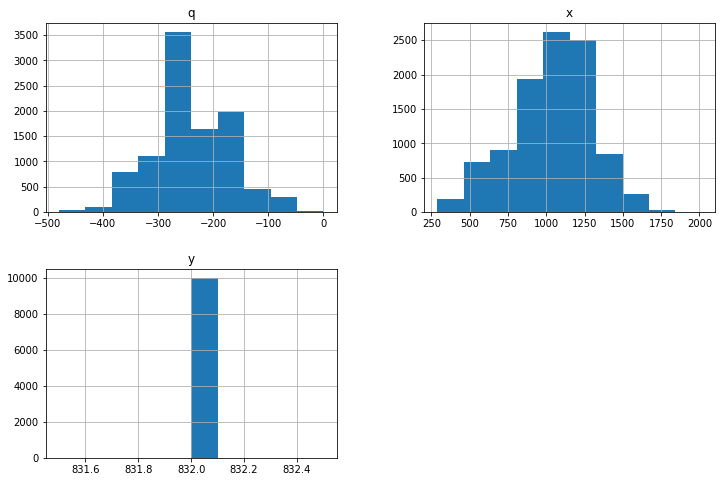

In [8]:
import pandas as pd

df = pd.DataFrame(stats)
df.hist(bins=10, figsize=(12, 8))
df.describe()